<a href="https://colab.research.google.com/github/FernandaSzAdr/CNN_cromossome/blob/master/TesteRede2_Colorida_Base2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).




---



In [0]:
!pip install imutils

import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.optimizers import SGD
from keras.layers.core import Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score

from skimage import transform

import cv2
import csv
import imutils
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os

Using TensorFlow backend.




---



## Funções

In [0]:
train_path = 'drive/My Drive/Base_CNN/Colorido2/Train'
test_path = 'drive/My Drive/Base_CNN/Colorido2/Test'
validation_path = 'drive/My Drive/Base_CNN/Colorido2/Validation'

In [0]:
def converte(regiao):
   regiao = np.array(regiao).astype('float32')/255
   regiao = transform.resize(regiao, (120, 120, 3))
   regiao = np.expand_dims(regiao, axis=0)
   return regiao


In [0]:
def ler_images_teste(arquiteture):
  y_true = []
  y_predict = []
  prob = []
  
  images_test = os.listdir(test_path)
  local = 'drive/My Drive/Resultado/Colorido/Resultado_Image/' + arquiteture
  if os.path.isdir(local) == False:
    os.mkdir(local)
  
  for img in images_test:
    # Pega cada imagem separadamente do folder de teste
    image = cv2.imread(test_path + '/' + img)
    image = imutils.resize(image, width=1000)
    f = open('drive/My Drive/Base_CNN/Binarizado2/posicoes_segmentada.csv', 'r')
    
    copia = image.copy()

    try:
      leitor = csv.reader(f)
      leitor = list(leitor)
      leitor.pop(0)
      for linha in leitor:
        if len(linha) > 0:
          # Para cada região dessa imagem:
          if linha[0] == img:
            posicoes = []
            x = int(linha[3])
            y = int(linha[4])
            w = int(linha[5])
            h = int(linha[6])
            
            # Label da região
            label = linha[1]
            if label == 'NC':
              y_true.append(0)
            else:
              y_true.append(1)
            
            # Região
            regiao = image[y: y + h, x: x + w]
            regiao = converte(regiao)
            
            # Coloca a região na função e obtem o resultado
            predicao = model.predict(regiao,batch_size=bSize,verbose=0)
            
            # Probabilidade de ser da classe 1
            prob.append(predicao[0][1])
            
            # Se é um cromossomo:
            if predicao[0][1] > predicao[0][0]:
              y_predict.append(1)
              cv2.rectangle(copia,(x, y),(x+w, y+h),(0,255,0), 1)
            # Se não for um cromossomo:
            else:
              y_predict.append(0)
              cv2.rectangle(copia,(x, y),(x+w, y+h),(0,0,255), 1)
                        
    finally:
      f.close()
    
    cv2.imwrite(local + '/' + img, copia)
  
  return y_true, y_predict, prob




---



# Implementação

## Variaveis globais



*   Batch size = 32
*   Image size = 120x120



In [0]:
results = {}

In [0]:
bSize = 32

In [0]:
datagen = ImageDataGenerator(rescale=1/255.)

In [0]:
train_batches = datagen.flow_from_directory(train_path, target_size=(120, 120), 
                                            classes=['NC', 'C'], 
                                            batch_size=bSize)
validation_batches = datagen.flow_from_directory(validation_path, 
                                                 target_size=(120, 120), 
                                                 classes=['NC', 'C'], 
                                                 batch_size=bSize)

Found 4369 images belonging to 2 classes.
Found 991 images belonging to 2 classes.


In [0]:
stepsPerEpoche = len(train_batches)/bSize
validationSteps = len(validation_batches)/bSize

In [0]:
train_batches.class_indices

{'C': 1, 'NC': 0}



---



## 1 tentativa - Test Precision: 0.00%, AUC: 0.740, Accuracy: 80.36%

**Descrição**


*   Modelo descrito no artigo "Crowdsourcing for Chromosome Segmentation and Deep Classification"



In [0]:
architecture = 'architecture_1'

### Modelo

In [0]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(120, 120, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(16, (3, 3), activation='relu'),
    Conv2D(16, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(8, (3, 3), activation='relu'),
    Conv2D(8, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(1024, activation='sigmoid'),
    Dense(512, activation='sigmoid'),
   
    Dense(2, activation='softmax')
]
)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 38s - loss: 0.7054 - acc: 0.4500 - val_loss: 0.7965 - val_acc: 0.4062

Epoch 00001: val_loss improved from inf to 0.79650, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_1.hdf5
Epoch 2/50
 - 37s - loss: 0.7123 - acc: 0.4813 - val_loss: 0.6906 - val_acc: 0.5625

Epoch 00002: val_loss improved from 0.79650 to 0.69061, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_1.hdf5
Epoch 3/50
 - 40s - loss: 0.6999 - acc: 0.5687 - val_loss: 0.7003 - val_acc: 0.5000

Epoch 00003: val_loss did not improve from 0.69061
Epoch 4/50
 - 37s - loss: 0.7103 - acc: 0.4750 - val_loss: 0.6869 - val_acc: 0.5625

Epoch 00004: val_loss improved from 0.69061 to 0.68690, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_1.hdf5
Epoch 5/50
 - 37s - loss: 0.7039 - acc: 0.5062 - val_loss: 0.6928 - val_acc: 0.5312

Epoch 00005: val_loss did not improve from 0.68690
Epoch 6/50
 - 36s - loss: 0.6914 - acc: 0.6063 - val_loss: 0.7482 - val_acc

In [0]:
model.load_weights('drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5')

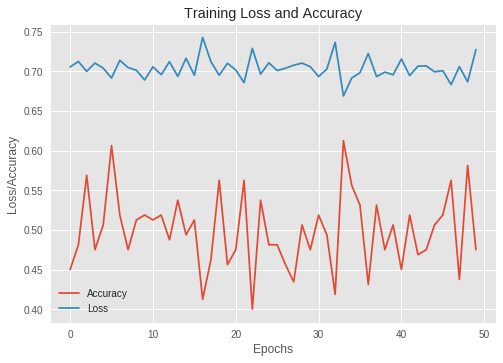

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Colorido/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [0]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 0.00%, AUC: 0.740, Accuracy: 80.36%


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


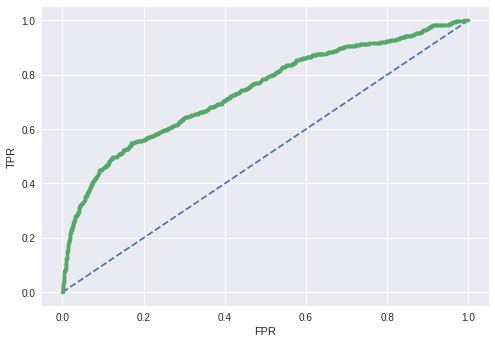

In [0]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Colorido/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 2 tentativa  - Test Precision: 64.02%, AUC: 0.917, Accuracy: 87.43%

**Descrição**


*   Modelo descrito no artigo "Crowdsourcing for Chromosome Segmentation and Deep Classification"
*   Alteração nas duas ultimas camadas Dense





In [0]:
architecture = 'architecture_2'

### Modelo

In [0]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(120, 120, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(16, (3, 3), activation='relu'),
    Conv2D(16, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(8, (3, 3), activation='relu'),
    Conv2D(8, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(512, activation='relu'),
   
    Dense(2, activation='softmax')
]
)

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 2s - loss: 0.6932 - acc: 0.4813 - val_loss: 0.6933 - val_acc: 0.4516

Epoch 00001: val_loss improved from inf to 0.69327, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_2.hdf5
Epoch 2/50
 - 1s - loss: 0.6932 - acc: 0.5125 - val_loss: 0.6934 - val_acc: 0.4688

Epoch 00002: val_loss did not improve from 0.69327
Epoch 3/50
 - 1s - loss: 0.6934 - acc: 0.4813 - val_loss: 0.6928 - val_acc: 0.5938

Epoch 00003: val_loss improved from 0.69327 to 0.69282, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_2.hdf5
Epoch 4/50
 - 1s - loss: 0.6931 - acc: 0.5250 - val_loss: 0.6936 - val_acc: 0.3750

Epoch 00004: val_loss did not improve from 0.69282
Epoch 5/50
 - 1s - loss: 0.6930 - acc: 0.5072 - val_loss: 0.6944 - val_acc: 0.4062

Epoch 00005: val_loss did not improve from 0.69282
Epoch 6/50
 - 1s - loss: 0.6916 - acc: 0.5812 - val_loss: 0.6940 - val_acc: 0.4688

Epoch 00006: val_loss did not improve from 0.69282
Epoch 7/50
 - 1s - loss: 0.6

In [0]:
model.load_weights('drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5')

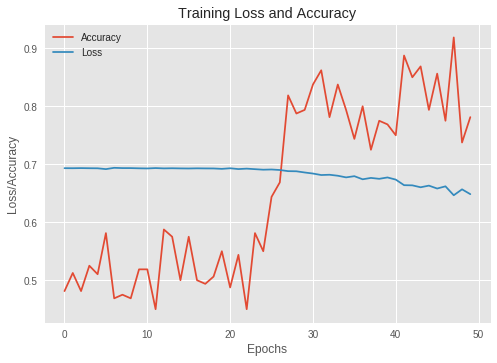

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Colorido/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [0]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 64.02%, AUC: 0.917, Accuracy: 87.43%


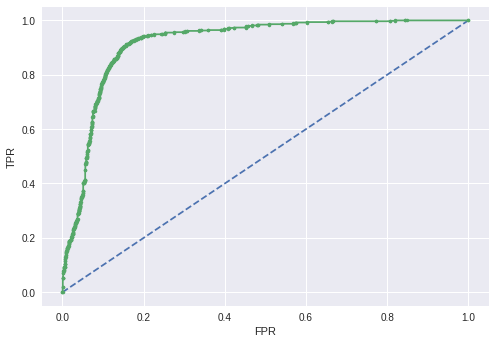

In [0]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Colorido/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 3 tentativa - Test Precision: 67.66%, AUC: 0.886, Accuracy: 83.94%

Modelo criado pelo **Lucas Valentim**

https://github.com/lucasvalentim/chromosome-recognizer/blob/master/chromosome_recognizer.ipynb

In [0]:
architecture = 'architecture_3'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 4s - loss: 1.3294 - acc: 0.5750 - val_loss: 0.4788 - val_acc: 0.8281

Epoch 00001: val_loss improved from inf to 0.47885, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_3.hdf5
Epoch 2/50
 - 1s - loss: 0.6897 - acc: 0.7375 - val_loss: 0.3310 - val_acc: 0.9032

Epoch 00002: val_loss improved from 0.47885 to 0.33096, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_3.hdf5
Epoch 3/50
 - 0s - loss: 0.4379 - acc: 0.8469 - val_loss: 0.5005 - val_acc: 0.7969

Epoch 00003: val_loss did not improve from 0.33096
Epoch 4/50
 - 0s - loss: 0.4160 - acc: 0.8531 - val_loss: 0.7331 - val_acc: 0.8125

Epoch 00004: val_loss did not improve from 0.33096
Epoch 5/50
 - 0s - loss: 0.5112 - acc: 0.8625 - val_loss: 0.9951 - val_acc: 0.6875

Epoch 00005: val_loss did not improve from 0.33096
Epoch 6/50
 - 0s - loss: 0.4631 - acc: 0.8500 - val_loss: 0.5814 - val_acc: 0.7969

Epoch 00006: val_loss did not improve from 0.33096
Epoch 7/50
 - 0s - loss: 0.3

In [0]:
model.load_weights('drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5')

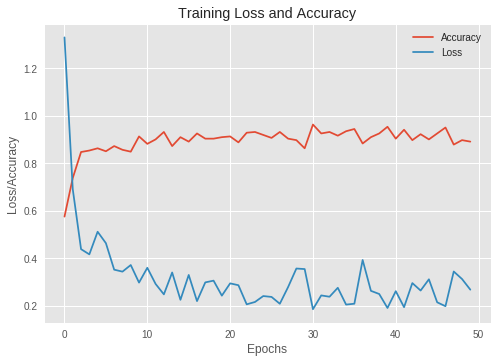

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Colorido/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [0]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 67.66%, AUC: 0.886, Accuracy: 83.94%


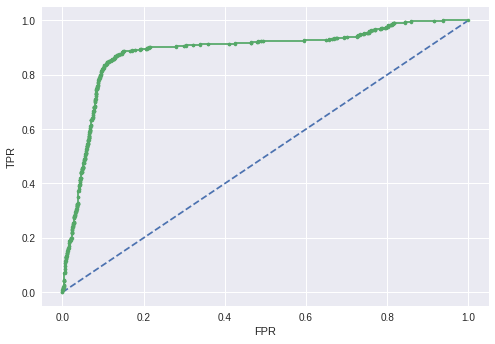

In [0]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Colorido/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 4 tentativa - Test Precision: 40.62%, AUC: 0.767, Accuracy: 72.86%

Modelo adaptado do **Lucas Valentim**

*   Sem os **dropout**


In [0]:
architecture = 'architecture_4'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 4s - loss: 0.6093 - acc: 0.7094 - val_loss: 0.5699 - val_acc: 0.7812

Epoch 00001: val_loss improved from inf to 0.56987, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_4.hdf5
Epoch 2/50
 - 1s - loss: 0.3726 - acc: 0.8719 - val_loss: 0.4507 - val_acc: 0.7969

Epoch 00002: val_loss improved from 0.56987 to 0.45072, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_4.hdf5
Epoch 3/50
 - 0s - loss: 0.2834 - acc: 0.9219 - val_loss: 1.2988 - val_acc: 0.6774

Epoch 00003: val_loss did not improve from 0.45072
Epoch 4/50
 - 0s - loss: 0.3137 - acc: 0.8875 - val_loss: 1.4420 - val_acc: 0.6094

Epoch 00004: val_loss did not improve from 0.45072
Epoch 5/50
 - 0s - loss: 0.3052 - acc: 0.9062 - val_loss: 2.8642 - val_acc: 0.4062

Epoch 00005: val_loss did not improve from 0.45072
Epoch 6/50
 - 0s - loss: 0.2329 - acc: 0.9406 - val_loss: 1.3912 - val_acc: 0.5938

Epoch 00006: val_loss did not improve from 0.45072
Epoch 7/50
 - 1s - loss: 0.2

In [0]:
model.load_weights('drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5')

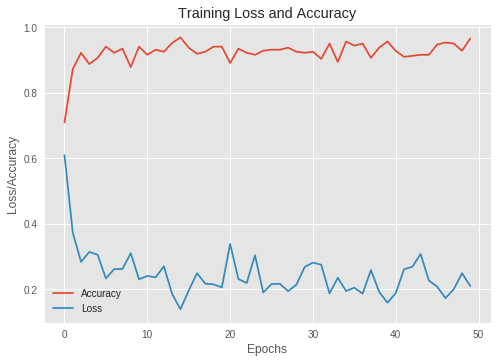

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Colorido/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [0]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 40.62%, AUC: 0.767, Accuracy: 72.86%


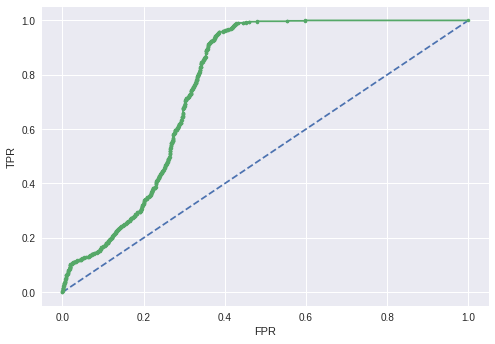

In [0]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Colorido/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 5 tentativa - Test Precision: 42.11%, AUC: 0.894, Accuracy: 75.32%

Modelo adaptado do **Lucas Valentim**

*   Sem os **dropout**
*   Função **SGD** para compilação


In [0]:
architecture = 'architecture_5'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 4s - loss: 1.2100 - acc: 0.5281 - val_loss: 0.7699 - val_acc: 0.5312

Epoch 00001: val_loss improved from inf to 0.76993, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_5.hdf5
Epoch 2/50
 - 0s - loss: 0.9189 - acc: 0.6375 - val_loss: 0.7562 - val_acc: 0.4688

Epoch 00002: val_loss improved from 0.76993 to 0.75617, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_5.hdf5
Epoch 3/50
 - 0s - loss: 0.7550 - acc: 0.7156 - val_loss: 0.6691 - val_acc: 0.6562

Epoch 00003: val_loss improved from 0.75617 to 0.66914, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_5.hdf5
Epoch 4/50
 - 0s - loss: 0.7856 - acc: 0.7406 - val_loss: 0.8082 - val_acc: 0.5161

Epoch 00004: val_loss did not improve from 0.66914
Epoch 5/50
 - 0s - loss: 0.4235 - acc: 0.8281 - val_loss: 0.6638 - val_acc: 0.7969

Epoch 00005: val_loss improved from 0.66914 to 0.66382, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_5.hd

In [0]:
model.load_weights('drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5')

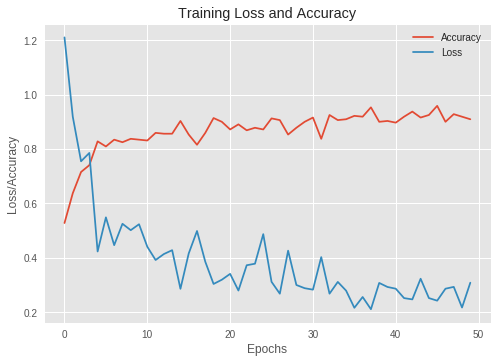

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Colorido/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [0]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 42.11%, AUC: 0.894, Accuracy: 75.32%


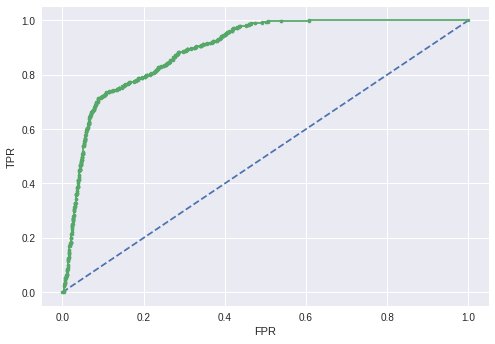

In [0]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Colorido/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 6 tentativa - Test Precision: 30.40%, AUC: 0.763, Accuracy: 57.80%

Modelo adaptado do **Lucas Valentim**

*   Sem os **dropout**
*   Função **SGD** para compilação
*   **BatchNormalization** antes da ultima camada Dense


In [0]:
architecture = 'architecture_6'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.03, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 4s - loss: 0.6752 - acc: 0.6937 - val_loss: 1.2132 - val_acc: 0.6094

Epoch 00001: val_loss improved from inf to 1.21317, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_6.hdf5
Epoch 2/50
 - 0s - loss: 0.4669 - acc: 0.8063 - val_loss: 0.4855 - val_acc: 0.8438

Epoch 00002: val_loss improved from 1.21317 to 0.48551, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_6.hdf5
Epoch 3/50
 - 0s - loss: 0.3308 - acc: 0.9000 - val_loss: 0.7923 - val_acc: 0.6875

Epoch 00003: val_loss did not improve from 0.48551
Epoch 4/50
 - 0s - loss: 0.3067 - acc: 0.8969 - val_loss: 0.6694 - val_acc: 0.8125

Epoch 00004: val_loss did not improve from 0.48551
Epoch 5/50
 - 0s - loss: 0.3611 - acc: 0.8812 - val_loss: 0.8272 - val_acc: 0.7258

Epoch 00005: val_loss did not improve from 0.48551
Epoch 6/50
 - 0s - loss: 0.3569 - acc: 0.8688 - val_loss: 1.6838 - val_acc: 0.5312

Epoch 00006: val_loss did not improve from 0.48551
Epoch 7/50
 - 0s - loss: 0.3

In [0]:
model.load_weights('drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5')

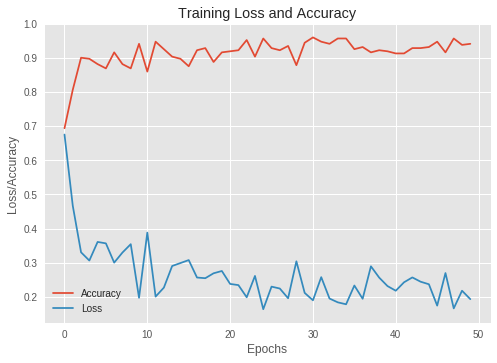

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Colorido/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [0]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 30.40%, AUC: 0.763, Accuracy: 57.80%


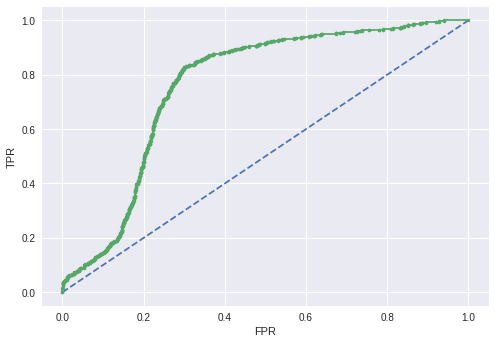

In [0]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Colorido/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 7 tentativa - Test Precision: 41.36%, AUC: 0.903, Accuracy: 72.74%

Modelo adaptado do **Lucas Valentim**

*   Sem os **dropout**
*   Função **Adadelta** para compilação
*   **BatchNormalization** antes da ultima camada Dense


In [0]:
architecture = 'architecture_7'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adadelta

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 4s - loss: 0.5571 - acc: 0.7781 - val_loss: 0.3629 - val_acc: 0.8906

Epoch 00001: val_loss improved from inf to 0.36292, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_7.hdf5
Epoch 2/50
 - 0s - loss: 0.3857 - acc: 0.8750 - val_loss: 0.8797 - val_acc: 0.7344

Epoch 00002: val_loss did not improve from 0.36292
Epoch 3/50
 - 1s - loss: 0.1702 - acc: 0.9562 - val_loss: 0.5004 - val_acc: 0.7500

Epoch 00003: val_loss did not improve from 0.36292
Epoch 4/50
 - 0s - loss: 0.3753 - acc: 0.8812 - val_loss: 0.6107 - val_acc: 0.7500

Epoch 00004: val_loss did not improve from 0.36292
Epoch 5/50
 - 0s - loss: 0.3469 - acc: 0.8625 - val_loss: 0.5648 - val_acc: 0.7969

Epoch 00005: val_loss did not improve from 0.36292
Epoch 6/50
 - 0s - loss: 0.3001 - acc: 0.8937 - val_loss: 0.1556 - val_acc: 0.9677

Epoch 00006: val_loss improved from 0.36292 to 0.15559, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_7.hdf5
Epoch 7/50
 - 0s - loss: 0.2

In [0]:
model.load_weights('drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5')

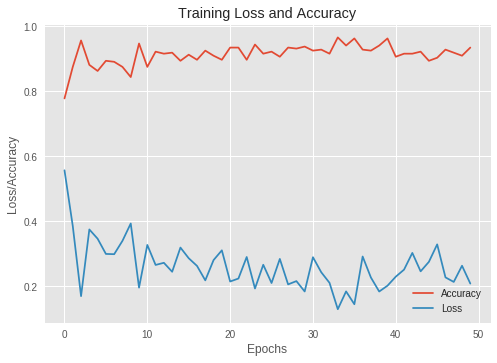

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Colorido/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [0]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 41.36%, AUC: 0.903, Accuracy: 72.74%


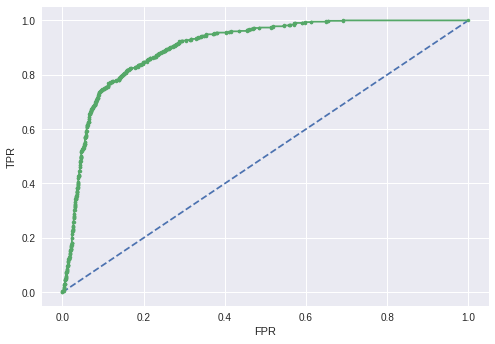

In [0]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Colorido/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 8 tentativa  - Test Precision: 43.41%, AUC: 0.780, Accuracy: 77.14%

Modelo adaptado do **Lucas Valentim**

*   Função **Adadelta** para compilação


In [0]:
architecture = 'architecture_8'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adadelta

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 5s - loss: 0.9737 - acc: 0.6500 - val_loss: 0.6645 - val_acc: 0.8125

Epoch 00001: val_loss improved from inf to 0.66451, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_8.hdf5
Epoch 2/50
 - 1s - loss: 0.9504 - acc: 0.7500 - val_loss: 0.7625 - val_acc: 0.8281

Epoch 00002: val_loss did not improve from 0.66451
Epoch 3/50
 - 1s - loss: 0.5180 - acc: 0.8719 - val_loss: 0.6852 - val_acc: 0.7812

Epoch 00003: val_loss did not improve from 0.66451
Epoch 4/50
 - 0s - loss: 0.4629 - acc: 0.8469 - val_loss: 1.1345 - val_acc: 0.6250

Epoch 00004: val_loss did not improve from 0.66451
Epoch 5/50
 - 0s - loss: 0.8374 - acc: 0.7870 - val_loss: 0.8989 - val_acc: 0.6250

Epoch 00005: val_loss did not improve from 0.66451
Epoch 6/50
 - 0s - loss: 0.5444 - acc: 0.8094 - val_loss: 0.7541 - val_acc: 0.7500

Epoch 00006: val_loss did not improve from 0.66451
Epoch 7/50
 - 1s - loss: 0.3860 - acc: 0.8625 - val_loss: 1.4534 - val_acc: 0.5484

Epoch 00007: val_loss did n

In [0]:
model.load_weights('drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5')

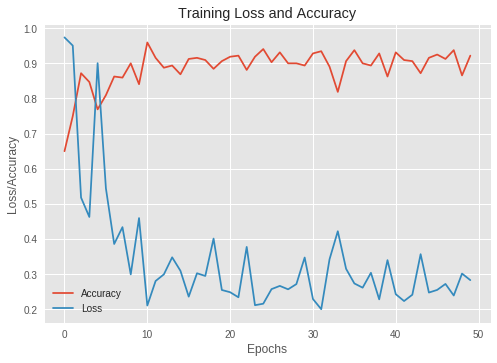

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Colorido/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [0]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 43.41%, AUC: 0.780, Accuracy: 77.14%


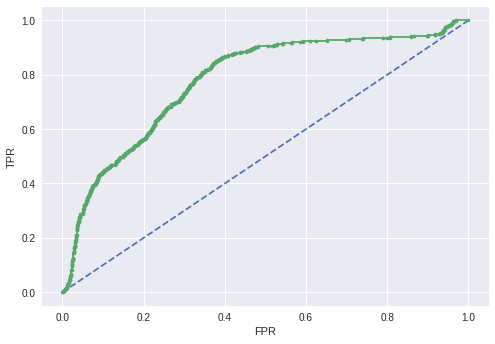

In [0]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Colorido/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 9 tentativa - Test Precision: 43.49%, AUC: 0.870, Accuracy: 75.23%

Modelo adaptado do **Lucas Valentim**

*   Função **SGD** para compilação


In [0]:
architecture = 'architecture_9'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.03, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 4s - loss: 1.4963 - acc: 0.6437 - val_loss: 0.9425 - val_acc: 0.6719

Epoch 00001: val_loss improved from inf to 0.94253, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_9.hdf5
Epoch 2/50
 - 0s - loss: 0.6694 - acc: 0.7719 - val_loss: 0.7043 - val_acc: 0.7969

Epoch 00002: val_loss improved from 0.94253 to 0.70432, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_9.hdf5
Epoch 3/50
 - 0s - loss: 0.7167 - acc: 0.7531 - val_loss: 1.0304 - val_acc: 0.6094

Epoch 00003: val_loss did not improve from 0.70432
Epoch 4/50
 - 0s - loss: 0.4199 - acc: 0.8719 - val_loss: 0.4213 - val_acc: 0.8750

Epoch 00004: val_loss improved from 0.70432 to 0.42126, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_9.hdf5
Epoch 5/50
 - 0s - loss: 0.5085 - acc: 0.8156 - val_loss: 1.0474 - val_acc: 0.6406

Epoch 00005: val_loss did not improve from 0.42126
Epoch 6/50
 - 0s - loss: 0.4792 - acc: 0.8531 - val_loss: 0.7398 - val_acc: 0.73

In [0]:
model.load_weights('drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5')

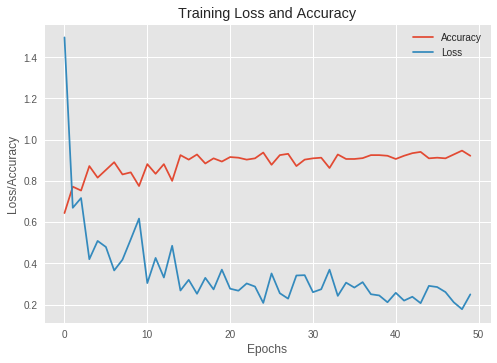

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Colorido/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [0]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 43.49%, AUC: 0.870, Accuracy: 75.23%


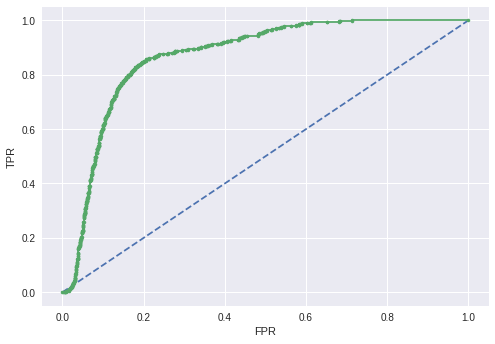

In [0]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Colorido/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 10 tentativa - Test Precision: 27.89%, AUC: 0.723, Accuracy: 57.01%

Modelo adaptado do **Lucas Valentim**

*   Função **adam** para compilação
*   Adicionado mais 2 camadas convolutivas

In [0]:
architecture = 'architecture_10'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 7s - loss: 1.3349 - acc: 0.5719 - val_loss: 0.1995 - val_acc: 1.0000

Epoch 00001: val_loss improved from inf to 0.19948, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_10.hdf5
Epoch 2/50
 - 1s - loss: 0.8913 - acc: 0.7750 - val_loss: 0.9131 - val_acc: 0.5938

Epoch 00002: val_loss did not improve from 0.19948
Epoch 3/50
 - 1s - loss: 0.5606 - acc: 0.8156 - val_loss: 0.3081 - val_acc: 0.8594

Epoch 00003: val_loss did not improve from 0.19948
Epoch 4/50
 - 1s - loss: 0.4799 - acc: 0.8281 - val_loss: 3.0621 - val_acc: 0.6094

Epoch 00004: val_loss did not improve from 0.19948
Epoch 5/50
 - 1s - loss: 0.5537 - acc: 0.8750 - val_loss: 1.1175 - val_acc: 0.7188

Epoch 00005: val_loss did not improve from 0.19948
Epoch 6/50
 - 1s - loss: 0.3500 - acc: 0.8937 - val_loss: 0.3837 - val_acc: 0.8750

Epoch 00006: val_loss did not improve from 0.19948
Epoch 7/50
 - 1s - loss: 0.2208 - acc: 0.9437 - val_loss: 0.4719 - val_acc: 0.7812

Epoch 00007: val_loss did 

In [0]:
model.load_weights('drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5')

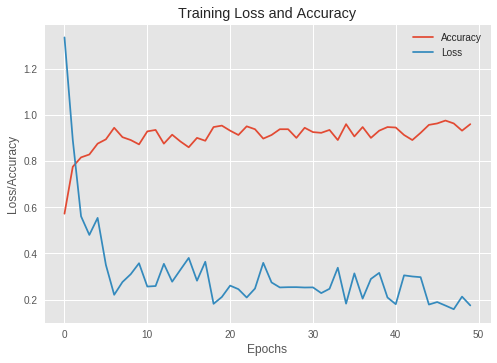

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Colorido/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [0]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 27.89%, AUC: 0.723, Accuracy: 57.01%


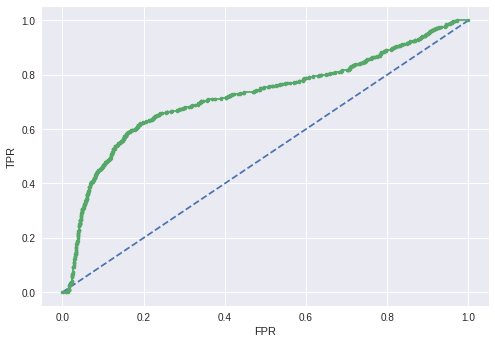

In [0]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Colorido/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 11 tentativa - Test Precision: 59.60%, AUC: 0.877, Accuracy: 84.73%

Modelo adaptado do **Lucas Albertins**

*   Função **SGD** para compilação
*   Adicionado mais 2 camadas convolutivas

In [0]:
architecture = 'architecture_11'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 6s - loss: 1.4689 - acc: 0.5344 - val_loss: 0.5717 - val_acc: 0.7812

Epoch 00001: val_loss improved from inf to 0.57167, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_11.hdf5
Epoch 2/50
 - 1s - loss: 0.9627 - acc: 0.6375 - val_loss: 0.6315 - val_acc: 0.7812

Epoch 00002: val_loss did not improve from 0.57167
Epoch 3/50
 - 1s - loss: 0.7413 - acc: 0.6969 - val_loss: 0.4114 - val_acc: 0.9062

Epoch 00003: val_loss improved from 0.57167 to 0.41143, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_11.hdf5
Epoch 4/50
 - 1s - loss: 0.5530 - acc: 0.8094 - val_loss: 0.7735 - val_acc: 0.6719

Epoch 00004: val_loss did not improve from 0.41143
Epoch 5/50
 - 1s - loss: 0.4467 - acc: 0.8469 - val_loss: 1.4871 - val_acc: 0.3281

Epoch 00005: val_loss did not improve from 0.41143
Epoch 6/50
 - 1s - loss: 0.4288 - acc: 0.8812 - val_loss: 0.5125 - val_acc: 0.8281

Epoch 00006: val_loss did not improve from 0.41143
Epoch 7/50
 - 1s - loss: 0

In [0]:
model.load_weights('drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5')

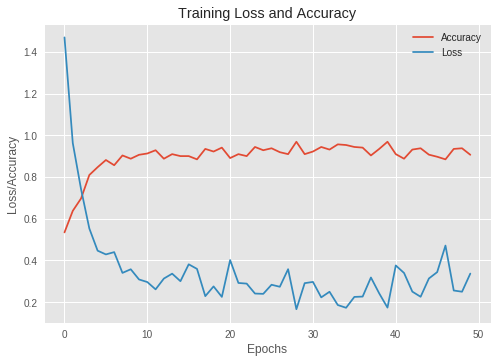

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Colorido/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [0]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 59.60%, AUC: 0.877, Accuracy: 84.73%


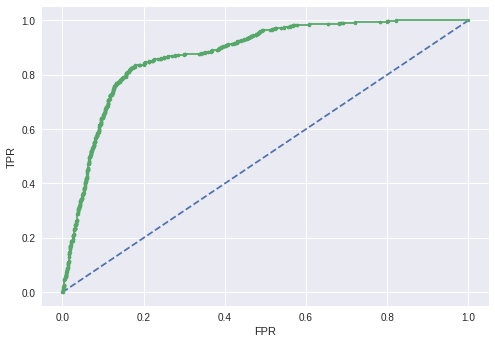

In [0]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Colorido/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 12 tentativa - Test Precision: 28.16%, AUC: 0.840, Accuracy: 52.00%

Modelo adaptado do **Lucas Valentim**

*   Sem utilização das funções de regularização
*   Função **SGD** para compilação
*   Adicionado mais 2 camadas convolutivas

In [0]:
architecture = 'architecture_12'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu',input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(96, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 6s - loss: 1.3501 - acc: 0.5375 - val_loss: 0.6948 - val_acc: 0.5469

Epoch 00001: val_loss improved from inf to 0.69481, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_12.hdf5
Epoch 2/50
 - 1s - loss: 0.6625 - acc: 0.6844 - val_loss: 0.4686 - val_acc: 0.8438

Epoch 00002: val_loss improved from 0.69481 to 0.46856, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_12.hdf5
Epoch 3/50
 - 1s - loss: 0.6075 - acc: 0.7438 - val_loss: 0.4484 - val_acc: 0.8594

Epoch 00003: val_loss improved from 0.46856 to 0.44842, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_12.hdf5
Epoch 4/50
 - 1s - loss: 0.3991 - acc: 0.8281 - val_loss: 0.9200 - val_acc: 0.5312

Epoch 00004: val_loss did not improve from 0.44842
Epoch 5/50
 - 1s - loss: 0.3701 - acc: 0.8625 - val_loss: 0.3899 - val_acc: 0.8594

Epoch 00005: val_loss improved from 0.44842 to 0.38994, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_1

In [0]:
model.load_weights('drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5')

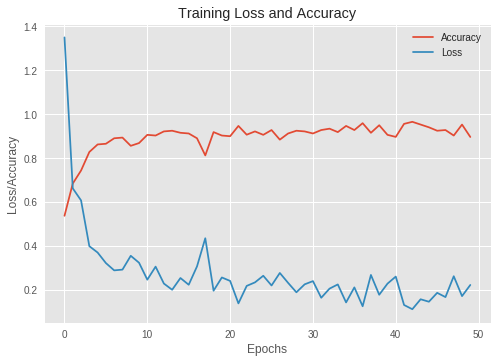

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Colorido/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [0]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 28.16%, AUC: 0.840, Accuracy: 52.00%


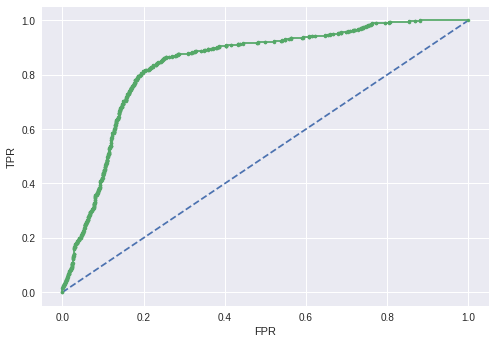

In [0]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Colorido/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 13 tentativa - Test Precision: 42.84%, AUC: 0.843, Accuracy: 75.38%

Modelo adaptado do ** Lucas Valentim**

*   Utilizado outra função de normalização, diferente da utilizada por ele.

In [0]:
architecture = 'architecture_13'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu',input_shape=(None, None, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(128, (7, 7),activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 6s - loss: 0.7132 - acc: 0.7344 - val_loss: 0.1810 - val_acc: 0.9844

Epoch 00001: val_loss improved from inf to 0.18101, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_13.hdf5
Epoch 2/50
 - 0s - loss: 0.3207 - acc: 0.8594 - val_loss: 0.1281 - val_acc: 0.9375

Epoch 00002: val_loss improved from 0.18101 to 0.12806, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_13.hdf5
Epoch 3/50
 - 0s - loss: 0.2642 - acc: 0.9125 - val_loss: 0.7574 - val_acc: 0.8594

Epoch 00003: val_loss did not improve from 0.12806
Epoch 4/50
 - 0s - loss: 0.3410 - acc: 0.8906 - val_loss: 0.2117 - val_acc: 0.9219

Epoch 00004: val_loss did not improve from 0.12806
Epoch 5/50
 - 0s - loss: 0.3249 - acc: 0.8750 - val_loss: 0.2085 - val_acc: 0.8750

Epoch 00005: val_loss did not improve from 0.12806
Epoch 6/50
 - 1s - loss: 0.3157 - acc: 0.8875 - val_loss: 0.4347 - val_acc: 0.7812

Epoch 00006: val_loss did not improve from 0.12806
Epoch 7/50
 - 1s - loss: 0

In [0]:
model.load_weights('drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5')

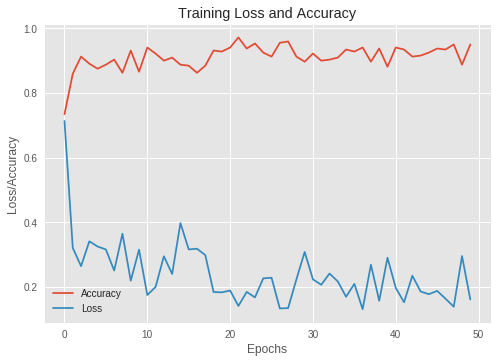

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Colorido/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [0]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 42.84%, AUC: 0.843, Accuracy: 75.38%


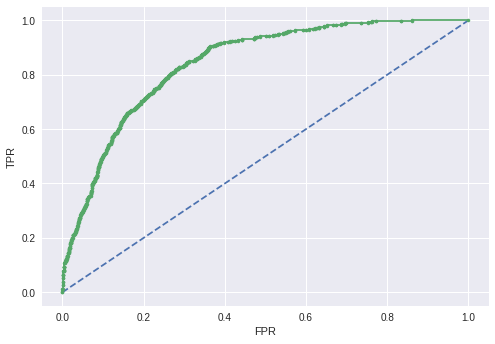

In [0]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Colorido/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## Mini VGG - Test Precision: 71.96%, AUC: 0.920, Accuracy: 89.34%

In [0]:
architecture = 'miniVGG_base2_colorida'

### Modelo

In [0]:
def build_MiniVGG(width, height, depth, classes):
  # initialize the model
  model = Sequential()
  
  inputShape = (height, width, depth)# first CONV => RELU => CONV => RELU => POOL layer set
  model.add(Conv2D(32, (3, 3), padding="same",
  input_shape=inputShape))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=2))
  model.add(Conv2D(32, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=2))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  
  # second CONV => RELU => CONV => RELU => POOL layer set
  model.add(Conv2D(64, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=2))
  model.add(Conv2D(64, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=2))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  
  # first (and only) set of FC => RELU layers
  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  
  # softmax classifier
  model.add(Dense(classes))
  model.add(Activation("softmax"))
  # return the constructed network architecture
  return model

In [0]:
model = build_MiniVGG(width=120, height=120, depth=3, classes=2)

opt = SGD(lr=0.01)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Treino

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Colorido/' + 
                               'weights_' + architecture + '.hdf5', verbose=1,
                               save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
 - 65s - loss: 0.8327 - acc: 0.7250 - val_loss: 7.5939 - val_acc: 0.4062

Epoch 00001: val_loss improved from inf to 7.59385, saving model to drive/My Drive/Resultado/Segmentado/weights_miniVGG_base2_colorida.hdf5
Epoch 2/50
 - 60s - loss: 0.4771 - acc: 0.9000 - val_loss: 0.9258 - val_acc: 0.6875

Epoch 00002: val_loss improved from 7.59385 to 0.92578, saving model to drive/My Drive/Resultado/Segmentado/weights_miniVGG_base2_colorida.hdf5
Epoch 3/50
 - 67s - loss: 0.6172 - acc: 0.8375 - val_loss: 2.5058 - val_acc: 0.5625

Epoch 00003: val_loss did not improve from 0.92578
Epoch 4/50
 - 64s - loss: 0.5329 - acc: 0.8812 - val_loss: 4.0334 - val_acc: 0.5000

Epoch 00004: val_loss did not improve from 0.92578
Epoch 5/50
 - 62s - loss: 0.3276 - acc: 0.8688 - val_loss: 4.1303 - val_acc: 0.5938

Epoch 00005: val_loss did not improve from 0.92578
Epoch 6/50
 - 60s - loss: 0.6514 - acc: 0.8750 - val_loss: 7.6470 - val_acc: 0.5000

Epoch

In [0]:
model.load_weights('drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5')

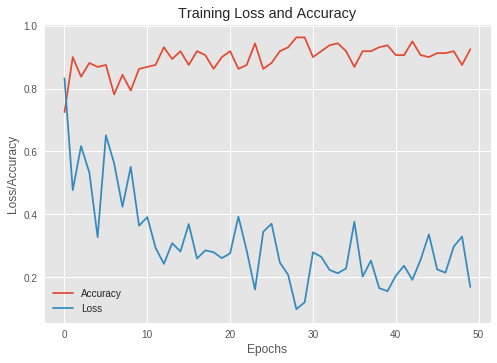

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Colorido/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [0]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 71.96%, AUC: 0.920, Accuracy: 89.34%


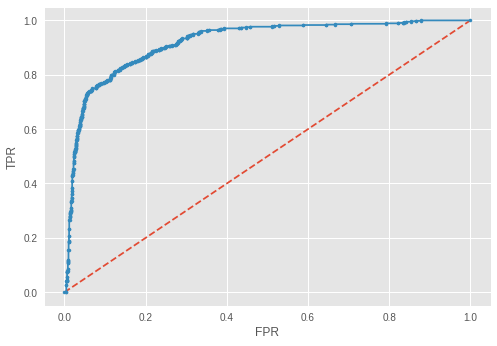

In [0]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Colorido/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')